In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

# Use float64 for higher precision in PDEs
tf.keras.backend.set_floatx('float64')
DTYPE = tf.float64

# Constants
omega = tf.constant(1.0, dtype=DTYPE)
x_min, x_max = tf.constant(-np.pi, dtype=DTYPE), tf.constant(np.pi, dtype=DTYPE)
t_min, t_max = tf.constant(0.0, dtype=DTYPE), tf.constant(2 * np.pi, dtype=DTYPE)

# Initial condition
@tf.function
def psi_init(x):
    return tf.exp(-tf.square(x) / tf.constant(2.0, dtype=DTYPE))

# Neural Network
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = [tf.keras.layers.Dense(512, activation='tanh') for _ in range(6)]
        self.out = tf.keras.layers.Dense(2, activation=None)  # [u, v]

    def call(self, X):
        x = X
        for layer in self.hidden:
            x = layer(x)
        return self.out(x)

# PDE Residual
@tf.function
def pde_residual(model, x, t):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([x, t])
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch([x, t])
            X = tf.concat([x, t], axis=1)
            uv = model(X)
            u, v = uv[:, 0:1], uv[:, 1:2]
        u_x = tape1.gradient(u, x)
        v_x = tape1.gradient(v, x)
        u_t = tape1.gradient(u, t)
        v_t = tape1.gradient(v, t)
    u_xx = tape2.gradient(u_x, x)
    v_xx = tape2.gradient(v_x, x)
    del tape1, tape2

    R_u = u_t + 0.5 * (v_xx - (omega**2) * x**2 * v)
    R_v = v_t - 0.5 * (u_xx - (omega**2) * x**2 * u)
    return R_u, R_v

# Loss Function
@tf.function
def loss_fn(model, interior, boundary, initial):
    x_f, t_f = interior
    x_b, t_b = boundary
    x_i, t_i, psi_i = initial

    R_u, R_v = pde_residual(model, x_f, t_f)
    loss_f = tf.reduce_mean(tf.square(R_u) + tf.square(R_v))

    uv_b = model(tf.concat([x_b, t_b], axis=1))
    loss_b = tf.reduce_mean(tf.square(uv_b))

    uv_i = model(tf.concat([x_i, t_i], axis=1))
    loss_i = tf.reduce_mean(tf.square(uv_i[:, 0:1] - tf.math.real(psi_i)) +
                            tf.square(uv_i[:, 1:2] - tf.math.imag(psi_i)))

    return loss_f + loss_b + loss_i, (loss_f, loss_b, loss_i)

# Training loop
def train(model, optimizer, epochs=10000):
    for epoch in range(epochs + 1):
        with tf.GradientTape() as tape:
            loss, (lf, lb, li) = loss_fn(model, (x_f, t_f), (x_b, t_b), (x_i, t_i, psi_i))
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if epoch % 500 == 0:
            print(f"Epoch {epoch}: Loss = {loss:.5e} (f = {lf:.5e}, b = {lb:.5e}, i = {li:.5e})")

    model.save_weights("pinn_tdse_weights.h5")

# Evaluation grid and plotting
def plot_solution(model, time_slices):
    x_plot = np.linspace(-np.pi, np.pi, 628)
    for t_val in time_slices:
        t_plot = np.full_like(x_plot, t_val)
        X_plot = tf.convert_to_tensor(np.stack([x_plot, t_plot], axis=1), dtype=DTYPE)
        uv = model(X_plot)
        u, v = uv[:, 0], uv[:, 1]
        density = u**2 + v**2

        plt.plot(x_plot, density, label=f't={t_val:.2f}')

    plt.title("|Psi(x, t)|^2 at different time slices")
    plt.xlabel("x")
    plt.ylabel("Density")
    plt.legend()
    plt.grid()
    plt.show()

# Data generation
N_f, N_b, N_i = 3140, 200, 314
x_f = tf.random.uniform((N_f, 1), x_min, x_max, dtype=DTYPE)
t_f = tf.random.uniform((N_f, 1), t_min, t_max, dtype=DTYPE)

x_b = tf.concat([
    tf.ones((N_b // 2, 1), dtype=DTYPE) * x_min,
    tf.ones((N_b // 2, 1), dtype=DTYPE) * x_max
], axis=0)
t_b = tf.random.uniform((N_b, 1), t_min, t_max, dtype=DTYPE)

x_i = tf.random.uniform((N_i, 1), x_min, x_max, dtype=DTYPE)
t_i = tf.zeros_like(x_i, dtype=DTYPE)
psi_i = tf.cast(psi_init(x_i), tf.complex128)

# Build and train model
model = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=2000,
    decay_rate=0.9
))

if os.path.exists("pinn_tdse_weights.h5"):
    print("Loading existing weights...")
    model.load_weights("pinn_tdse_weights.h5")
else:
    print("Training from scratch...")
    train(model, optimizer)

# Plot solution at specific time slices
time_slices = [0.0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
plot_solution(model, time_slices)


Training from scratch...
Epoch 0: Loss = 5.14308e-01 (f = 1.87753e-01, b = 1.86173e-02, i = 3.07938e-01)
Epoch 500: Loss = 9.70311e-02 (f = 2.28102e-02, b = 1.60987e-03, i = 7.26111e-02)
Epoch 1000: Loss = 1.15139e-02 (f = 1.05563e-02, b = 5.18191e-05, i = 9.05833e-04)
Epoch 1500: Loss = 6.91755e-03 (f = 6.49421e-03, b = 1.78203e-05, i = 4.05515e-04)
Epoch 2000: Loss = 8.94686e-03 (f = 8.06460e-03, b = 5.10540e-05, i = 8.31211e-04)
Epoch 2500: Loss = 3.49615e-03 (f = 3.35413e-03, b = 1.09316e-05, i = 1.31087e-04)
Epoch 3000: Loss = 2.21917e-03 (f = 2.14106e-03, b = 1.46076e-05, i = 6.35043e-05)
Epoch 3500: Loss = 1.10168e-03 (f = 1.05648e-03, b = 2.03955e-05, i = 2.48027e-05)
Epoch 4000: Loss = 5.41198e-04 (f = 5.02762e-04, b = 2.89696e-05, i = 9.46679e-06)
Epoch 4500: Loss = 3.13196e-04 (f = 2.74503e-04, b = 3.39572e-05, i = 4.73577e-06)
Epoch 5000: Loss = 3.52273e-04 (f = 3.09958e-04, b = 2.96192e-05, i = 1.26965e-05)
Epoch 5500: Loss = 1.80881e-04 (f = 1.47256e-04, b = 2.99270e-05, 

ValueError: The filename must end in `.weights.h5`. Received: filepath=pinn_tdse_weights.h5

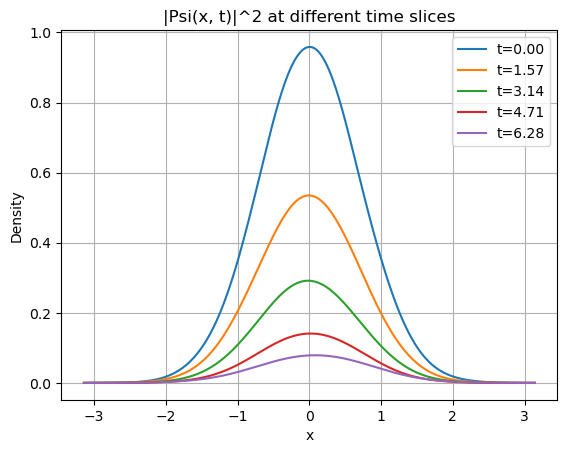

In [3]:
# Plot solution at specific time slices
time_slices = [0.0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
plot_solution(model, time_slices)

In [8]:
# Save the model in Keras format
model_save_path = "Schrodinger_equation_v1.keras"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

# Save original weights
original_weights = model.get_weights()

# Load the model
loaded_pinn = tf.keras.models.load_model(model_save_path, custom_objects={'PINN': PINN})

# Check if the weights match
loaded_weights = loaded_pinn.get_weights()

for orig, loaded in zip(original_weights, loaded_weights):
    if not np.array_equal(orig, loaded):
        print("Weights do not match after loading!")
    else:
        print("Weights match.")

# Check prediction consistency
x_test = np.linspace(x_min, x_max, 100).reshape(-1,1).astype(np.float32)
t_test = np.linspace(t_min, t_max, 100).reshape(-1,1).astype(np.float32)

x_test_tensor = tf.convert_to_tensor(x_test)
t_test_tensor = tf.convert_to_tensor(t_test)

original_prediction = PINN(tf.concat([x_test_tensor, t_test_tensor], axis=1)).numpy()
loaded_prediction = loaded_pinn(tf.concat([x_test_tensor, t_test_tensor], axis=1)).numpy()

if not np.allclose(original_prediction, loaded_prediction, atol=1e-5):
    print("Predictions do not match after loading!")
else:
    print("Predictions match.")

Model saved to Schrodinger_equation_v1.keras


TypeError: <class '__main__.PINN'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': None, 'class_name': 'PINN', 'config': {'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float64'}, 'registered_name': None}}, 'registered_name': 'PINN', 'build_config': {'input_shape': [3140, 2]}}.

Exception encountered: Unable to revive model from config. When overriding the `get_config()` method, make sure that the returned config contains all items used as arguments in the  constructor to <class '__main__.PINN'>, which is the default behavior. You can override this default behavior by defining a `from_config(cls, config)` class method to specify how to create an instance of PINN from its config.

Received config={'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float64'}, 'registered_name': None}}

Error encountered during deserialization: PINN.__init__() got an unexpected keyword argument 'trainable'